In [2]:
import pandas as pd
import inventorize3 as inv 
import datetime
import numpy as np

In [3]:
import os
path = os.getcwd()

In [4]:
retail = pd.read_csv('{0}/retail_clean.csv'.format(path))

In [5]:
retail = retail.drop_duplicates()

In [6]:
retail = retail.dropna(axis=0)

In [7]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 779495 entries, 0 to 779494
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   779495 non-null  int64  
 1   Invoice      779495 non-null  int64  
 2   StockCode    779495 non-null  object 
 3   Description  779495 non-null  object 
 4   Quantity     779495 non-null  int64  
 5   InvoiceDate  779495 non-null  object 
 6   Price        779495 non-null  float64
 7   Customer ID  779495 non-null  float64
 8   Country      779495 non-null  object 
 9   Revenue      779495 non-null  float64
dtypes: float64(3), int64(3), object(4)
memory usage: 65.4+ MB


In [8]:
retail.InvoiceDate

0         2009-12-01 07:45:00
1         2009-12-01 07:45:00
2         2009-12-01 07:45:00
3         2009-12-01 07:45:00
4         2009-12-01 07:45:00
                 ...         
779490    2011-12-09 12:50:00
779491    2011-12-09 12:50:00
779492    2011-12-09 12:50:00
779493    2011-12-09 12:50:00
779494    2011-12-09 12:50:00
Name: InvoiceDate, Length: 779495, dtype: object

In [9]:
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'])

In [10]:
retail['date'] = retail.InvoiceDate.dt.strftime('%Y-%m-%d')

In [11]:
retail['date'] = pd.to_datetime(retail['date'])

In [12]:
max_date = max(retail.date)

In [23]:
last_four = retail[retail.date > '2011-08-01']

In [24]:
last_four.columns

Index(['Unnamed: 0', 'Invoice', 'StockCode', 'Description', 'Quantity',
       'InvoiceDate', 'Price', 'Customer ID', 'Country', 'Revenue', 'date'],
      dtype='object')

In [25]:
last_four['revenue'] = last_four['Quantity'] * last_four['Price']

ipykernel_launcher:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [26]:
a = last_four.groupby(['date', 'Description']).agg(
    total_daily=('Quantity', np.sum),
    total_revenue = ('revenue', np.sum)).reset_index()

In [27]:
grouped = a.groupby('Description').agg(
    average=('total_daily', np.mean),
    sd = ('total_daily', 'std'),
    total_sales = ('total_daily', np.sum),
    total_revenue = ('total_revenue', np.sum)
    ).reset_index()

In [28]:
for_abc = inv.productmix(grouped['Description'], 
grouped['total_sales'],
grouped['total_revenue']
)
for_abc.product_mix.value_counts()

C_C    1455
A_A     487
B_B     330
C_B     241
B_C     230
A_B     228
B_A     169
A_C      41
C_A      34
Name: product_mix, dtype: int64

In [29]:
lead_time=12
sd_leadtime=2

mapping={'A_A':0.95,"A_C": 0.95,"C_A":0.8,"A_B":0.95,
         'B_A':0.7,"B_C":0.75,"C_C":0.7,"B_B":0.7,"C_B": 0.8}

for_abc['service_level']=for_abc.product_mix.map(mapping)


In [30]:
for_abc['service_level']

1904    0.95
2158    0.95
2259    0.95
1428    0.95
1898    0.95
        ... 
1282    0.70
3095    0.70
2403    0.70
546     0.70
1864    0.70
Name: service_level, Length: 3215, dtype: float64

In [31]:
### reorder point

In [33]:
pd.DataFrame(inv.reorderpoint(dailydemand=80, dailystandarddeviation = 10,leadtimein_days=12, csl=0.75), index=[0])

,demandleadtime,sigmadl,safteyfactor,reorder_point
0,960,34.641016,0.67449,983.36501


In [34]:
abcd = for_abc[['skus', 'service_level']]

In [35]:
for_reorder = pd.merge(grouped, abcd, how ='left', left_on='Description', right_on='skus')
for_reorder.columns

Index(['Description', 'average', 'sd', 'total_sales', 'total_revenue', 'skus',
       'service_level'],
      dtype='object')

In [36]:
empty_data = pd.DataFrame()

In [37]:
for i in range(for_reorder.shape[0]):
    ordering_point = inv.reorderpoint(
        for_reorder.loc[i, 'average'],
        for_reorder.loc[i, 'sd'],
        12,
        for_reorder.loc[i, 'service_level']                                 )
    as_data = pd.DataFrame(ordering_point, index=[0])
    as_data['Description'] = for_reorder.loc[i, 'Description']
    empty_data = pd.concat([empty_data, as_data], axis=0)

In [38]:
empty_data

,demandleadtime,sigmadl,safteyfactor,reorder_point,Description
0,63.600000,21.149095,0.524401,74.690596,4 PURPLE FLOCK DINNER CANDLES
0,377.000000,192.264957,1.644854,693.247711,50'S CHRISTMAS GIFT BAG LARGE
0,362.649351,255.704367,1.644854,783.245606,DOLLY GIRL BEAKER
0,97.909091,41.454552,0.524401,119.647879,I LOVE LONDON MINI BACKPACK
0,12.000000,NaN,0.524401,NaN,I LOVE LONDON MINI RUCKSACK
...,...,...,...,...,...
0,373.518987,130.531891,1.644854,588.224841,ZINC T-LIGHT HOLDER STARS SMALL
0,12.000000,NaN,0.524401,NaN,ZINC TOP 2 DOOR WOODEN SHELF
0,295.130435,106.662170,1.644854,470.574091,ZINC WILLIE WINKIE CANDLE STICK
0,32.571429,10.337173,0.524401,37.992247,ZINC WIRE KITCHEN ORGANISER


In [39]:
### joining all

In [40]:
all_data = pd.merge(for_reorder, empty_data, how='left')

In [41]:
all_data.columns

Index(['Description', 'average', 'sd', 'total_sales', 'total_revenue', 'skus',
       'service_level', 'demandleadtime', 'sigmadl', 'safteyfactor',
       'reorder_point'],
      dtype='object')

In [42]:
all_data['safety_stock'] = all_data['reorder_point'] - all_data['demandleadtime']

In [43]:
all_data[all_data.safety_stock == max(all_data.safety_stock)]

,Description,average,sd,total_sales,total_revenue,skus,service_level,demandleadtime,sigmadl,safteyfactor,reorder_point,safety_stock
222,ASSTD DESIGN 3D PAPER STICKERS,1590.5,4424.387803,12724,95.68,ASSTD DESIGN 3D PAPER STICKERS,0.95,19086.0,15326.528933,1.644854,44295.896704,25209.896704


In [44]:
import seaborn as sns

In [47]:
all_data = all_data[all_data.safety_stock != max(all_data.safety_stock)]

<AxesSubplot:xlabel='sd', ylabel='safety_stock'>

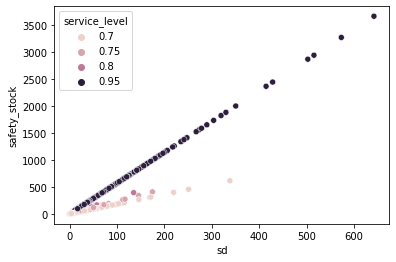

In [48]:
sns.scatterplot(x='sd', y='safety_stock', hue='service_level', data=all_data)

In [49]:
### with leadtime variability

In [50]:
empty_data_ltv = pd.DataFrame()

In [51]:
for i in range(for_reorder.shape[0]):
    ordering_point = inv.reorderpoint_leadtime_variability(
        int(for_reorder.loc[i,'average']),
        for_reorder.loc[i,'sd'],
        12,
        2,
        for_reorder.loc[i, 'service_level']
    )
    as_data = pd.DataFrame(ordering_point, index = [0])
    as_data['Description'] = for_reorder.loc[i, 'Description']
    empty_data_ltv = pd.concat([empty_data_ltv, as_data], axis=0)

In [52]:
empty_data_ltv

,demandleadtime,sigmadl,safteyfactor,reorder_point,Description
0,60,22.254982,0.524401,71.670524,4 PURPLE FLOCK DINNER CANDLES
0,372,197.194862,1.644854,696.356684,50'S CHRISTMAS GIFT BAG LARGE
0,360,259.204018,1.644854,786.352670,DOLLY GIRL BEAKER
0,96,42.993952,0.524401,118.546051,I LOVE LONDON MINI BACKPACK
0,12,NaN,0.524401,NaN,I LOVE LONDON MINI RUCKSACK
...,...,...,...,...,...
0,372,137.690139,1.644854,598.480125,ZINC T-LIGHT HOLDER STARS SMALL
0,12,NaN,0.524401,NaN,ZINC TOP 2 DOOR WOODEN SHELF
0,288,111.941138,1.644854,472.126787,ZINC WILLIE WINKIE CANDLE STICK
0,24,10.810048,0.524401,29.668795,ZINC WIRE KITCHEN ORGANISER


In [53]:
all_data_ltv = pd.merge(for_reorder, empty_data_ltv, how = 'left')

In [55]:
all_data.columns

Index(['Description', 'average', 'sd', 'total_sales', 'total_revenue', 'skus',
       'service_level', 'demandleadtime', 'sigmadl', 'safteyfactor',
       'reorder_point', 'safety_stock'],
      dtype='object')